# Credit Scoring: Ensemble Model Comparison
## Random Forest vs XGBoost vs LightGBM with Threshold Optimization

**Objective**: Compare multiple ensemble models and find optimal classification thresholds for imbalanced credit default prediction

**Models**:
1. Random Forest with balanced class weights
2. XGBoost with scale_pos_weight
3. LightGBM with scale_pos_weight

**Key Features**:
- Threshold optimization for each model
- Comprehensive performance comparison
- Business cost analysis
- Model ensemble/stacking

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# Models
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Model Selection & Validation
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split

# Metrics
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    make_scorer, balanced_accuracy_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve, auc
)

# Utilities
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")
print(f"📅 Notebook run date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully
📅 Notebook run date: 2025-11-13 00:22:54


In [2]:
# Load and Prepare Data
print("="*80)
print("DATA LOADING AND PREPARATION")
print("="*80)

df = pd.read_parquet(
    r'C:\Users\Asus\Documents\GitHub\Credit-Scoring\data\data-processing\flat_table\flat_credit_model_20251027_143321.parquet',
    engine="fastparquet"
)

print(f"\n📊 Dataset Shape: {df.shape}")
print(f"\n📈 Class Distribution:")
class_dist = df["TARGET"].value_counts()
print(f"  No Default (0): {class_dist[0]:,} ({class_dist[0]/len(df)*100:.2f}%)")
print(f"  Default (1): {class_dist[1]:,} ({class_dist[1]/len(df)*100:.2f}%)")

# Separate features and target
X = df.drop(columns=["TARGET", "SK_ID_CURR"])
y = df["TARGET"].astype(int)

# Handle missing values
X = X.fillna(0)

print(f"\n✅ Features: {X.shape[1]}")
print(f"✅ Total Samples: {X.shape[0]:,}")

# Calculate class weights
class_counts = Counter(y)
majority_count = class_counts[0]
minority_count = class_counts[1]
imbalance_ratio = majority_count / minority_count

print(f"\n⚖️ Imbalance Ratio: {imbalance_ratio:.2f}:1")

DATA LOADING AND PREPARATION

📊 Dataset Shape: (307511, 66)

📈 Class Distribution:
  No Default (0): 282,686 (91.93%)
  Default (1): 24,825 (8.07%)

✅ Features: 64
✅ Total Samples: 307,511

⚖️ Imbalance Ratio: 11.39:1


In [3]:
# Train-Test Split (Stratified)
print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

print(f"\nClass distribution in train:")
train_dist = pd.Series(y_train).value_counts(normalize=True)
print(f"  No Default: {train_dist[0]*100:.2f}%")
print(f"  Default: {train_dist[1]*100:.2f}%")

print(f"\nClass distribution in test:")
test_dist = pd.Series(y_test).value_counts(normalize=True)
print(f"  No Default: {test_dist[0]*100:.2f}%")
print(f"  Default: {test_dist[1]*100:.2f}%")

TRAIN-TEST SPLIT

Training Set: (246008, 64)
Test Set: (61503, 64)

Class distribution in train:
  No Default: 91.93%
  Default: 8.07%

Class distribution in test:
  No Default: 91.93%
  Default: 8.07%


## Model 1: Random Forest with Balanced Class Weights

In [4]:
# Train Random Forest
print("="*80)
print("RANDOM FOREST MODEL")
print("="*80)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',
    class_weight='balanced',  # Automatic class balancing
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n🌳 Training Random Forest...")
rf_model.fit(X_train, y_train)

print("\n✅ Training completed!")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Max depth: {rf_model.max_depth}")

RANDOM FOREST MODEL

🌳 Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   41.5s



✅ Training completed!
Number of trees: 300
Max depth: 12


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished


## Model 2: XGBoost with Scale Pos Weight

In [6]:
# Train XGBoost
print("="*80)
print("XGBOOST MODEL")
print("="*80)

# Calculate scale_pos_weight
scale_pos_weight_xgb = imbalance_ratio * 4.0
print(f"\nScale Pos Weight: {scale_pos_weight_xgb:.2f}")

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight_xgb,
    objective='binary:logistic',
    eval_metric='auc',
    early_stopping_rounds=50,  # Move it here as a parameter
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("\n🚀 Training XGBoost...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

print("\n✅ Training completed!")
print(f"Best iteration: {xgb_model.best_iteration}")
print(f"Best AUC: {xgb_model.best_score:.4f}")

XGBOOST MODEL

Scale Pos Weight: 45.55

🚀 Training XGBoost...
[0]	validation_0-auc:0.63771
[100]	validation_0-auc:0.70138
[200]	validation_0-auc:0.70376
[260]	validation_0-auc:0.70405

✅ Training completed!
Best iteration: 210
Best AUC: 0.7042


## Model 3: LightGBM with Scale Pos Weight

In [7]:
# Train LightGBM
print("="*80)
print("LIGHTGBM MODEL")
print("="*80)

# Calculate scale_pos_weight
scale_pos_weight_lgb = imbalance_ratio * 4.0
print(f"\nScale Pos Weight: {scale_pos_weight_lgb:.2f}")

lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=6,
    min_child_samples=20,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=0.1,
    subsample=0.8,
    subsample_freq=5,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight_lgb,
    objective='binary',
    boosting_type='gbdt',
    metric='auc',
    random_state=42,
    n_jobs=-1
)

print("\n💡 Training LightGBM...")
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['auc', 'binary_logloss'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

print("\n✅ Training completed!")
print(f"Best iteration: {lgb_model.best_iteration_}")
print(f"Best AUC: {lgb_model.best_score_['valid_0']['auc']:.4f}")

LIGHTGBM MODEL

Scale Pos Weight: 45.55

💡 Training LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10280
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[100]	valid_0's binary_logloss: 1.28955	valid_0's auc: 0.702235

✅ Training completed!
Best iteration: 1
Best AUC: 0.6397


## Generate Predictions for All Models

In [8]:
# Generate Predictions
print("="*80)
print("GENERATING PREDICTIONS")
print("="*80)

# Random Forest
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
print("✅ Random Forest predictions generated")

# XGBoost
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
print("✅ XGBoost predictions generated")

# LightGBM
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]
print("✅ LightGBM predictions generated")

# Calculate initial ROC-AUC scores
print("\n📊 Initial ROC-AUC Scores:")
print(f"  Random Forest: {roc_auc_score(y_test, y_prob_rf):.4f}")
print(f"  XGBoost: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print(f"  LightGBM: {roc_auc_score(y_test, y_prob_lgb):.4f}")

GENERATING PREDICTIONS


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.6s finished


✅ Random Forest predictions generated
✅ XGBoost predictions generated
✅ LightGBM predictions generated

📊 Initial ROC-AUC Scores:
  Random Forest: 0.6939
  XGBoost: 0.7042
  LightGBM: 0.6397


## Threshold Optimization Function

In [9]:
# Threshold Optimization Function
def find_optimal_threshold(y_true, y_prob, metric='f1', min_threshold=0.05, max_threshold=0.95):
    """
    Find optimal classification threshold
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_prob : array-like
        Predicted probabilities
    metric : str
        Metric to optimize ('f1', 'recall', 'precision', 'balanced_accuracy')
    
    Returns:
    --------
    dict : Dictionary with optimal threshold and metrics
    """
    thresholds = np.arange(min_threshold, max_threshold, 0.01)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        if y_pred.sum() > 0:  # At least one positive prediction
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            balanced_acc = balanced_accuracy_score(y_true, y_pred)
            
            results.append({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'balanced_accuracy': balanced_acc
            })
    
    results_df = pd.DataFrame(results)
    
    # Find best threshold based on metric
    best_idx = results_df[metric].idxmax()
    optimal = results_df.loc[best_idx].to_dict()
    
    return optimal, results_df

print("✅ Threshold optimization function defined")

✅ Threshold optimization function defined


## Optimize Thresholds for Each Model

In [10]:
# Optimize Thresholds
print("="*80)
print("THRESHOLD OPTIMIZATION")
print("="*80)

# Random Forest
print("\n🌳 Random Forest Threshold Optimization...")
rf_optimal, rf_threshold_df = find_optimal_threshold(y_test, y_prob_rf, metric='f1')
print(f"  Optimal Threshold: {rf_optimal['threshold']:.3f}")
print(f"  F1-Score: {rf_optimal['f1']:.4f}")
print(f"  Precision: {rf_optimal['precision']:.4f}")
print(f"  Recall: {rf_optimal['recall']:.4f}")

# XGBoost
print("\n🚀 XGBoost Threshold Optimization...")
xgb_optimal, xgb_threshold_df = find_optimal_threshold(y_test, y_prob_xgb, metric='f1')
print(f"  Optimal Threshold: {xgb_optimal['threshold']:.3f}")
print(f"  F1-Score: {xgb_optimal['f1']:.4f}")
print(f"  Precision: {xgb_optimal['precision']:.4f}")
print(f"  Recall: {xgb_optimal['recall']:.4f}")

# LightGBM
print("\n💡 LightGBM Threshold Optimization...")
lgb_optimal, lgb_threshold_df = find_optimal_threshold(y_test, y_prob_lgb, metric='f1')
print(f"  Optimal Threshold: {lgb_optimal['threshold']:.3f}")
print(f"  F1-Score: {lgb_optimal['f1']:.4f}")
print(f"  Precision: {lgb_optimal['precision']:.4f}")
print(f"  Recall: {lgb_optimal['recall']:.4f}")

THRESHOLD OPTIMIZATION

🌳 Random Forest Threshold Optimization...
  Optimal Threshold: 0.550
  F1-Score: 0.2453
  Precision: 0.1859
  Recall: 0.3601

🚀 XGBoost Threshold Optimization...
  Optimal Threshold: 0.860
  F1-Score: 0.2600
  Precision: 0.2017
  Recall: 0.3656

💡 LightGBM Threshold Optimization...
  Optimal Threshold: 0.120
  F1-Score: 0.1768
  Precision: 0.0992
  Recall: 0.8105


## Visualize Threshold Optimization

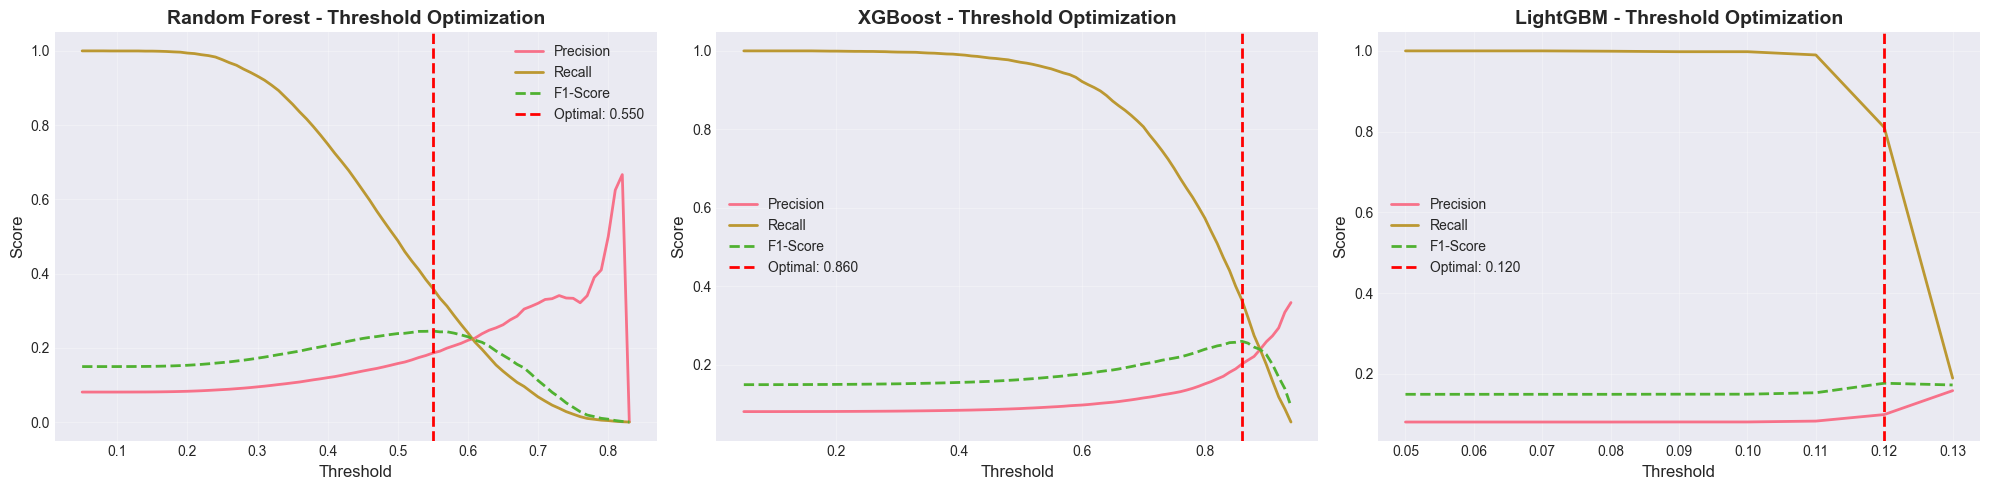

In [11]:
# Visualize Threshold Optimization
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

models_data = [
    ('Random Forest', rf_threshold_df, rf_optimal),
    ('XGBoost', xgb_threshold_df, xgb_optimal),
    ('LightGBM', lgb_threshold_df, lgb_optimal)
]

for idx, (name, df, optimal) in enumerate(models_data):
    ax = axes[idx]
    
    ax.plot(df['threshold'], df['precision'], label='Precision', linewidth=2)
    ax.plot(df['threshold'], df['recall'], label='Recall', linewidth=2)
    ax.plot(df['threshold'], df['f1'], label='F1-Score', linewidth=2, linestyle='--')
    ax.axvline(optimal['threshold'], color='red', linestyle='--', 
               label=f"Optimal: {optimal['threshold']:.3f}", linewidth=2)
    
    ax.set_xlabel('Threshold', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'{name} - Threshold Optimization', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Detailed Model Evaluation with Optimal Thresholds

In [12]:
# Evaluate Models with Optimal Thresholds
def evaluate_model(y_true, y_prob, threshold, model_name):
    """
    Evaluate model with given threshold
    """
    y_pred = (y_prob >= threshold).astype(int)
    
    print("="*80)
    print(f"{model_name.upper()} - DETAILED EVALUATION")
    print("="*80)
    print(f"\nOptimal Threshold: {threshold:.3f}")
    
    # Metrics
    roc_auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    
    print(f"\n📊 Performance Metrics:")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Balanced Accuracy: {balanced_acc:.4f}")
    
    # Classification Report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, 
                              target_names=['No Default (0)', 'Default (1)'],
                              digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n💼 Business Metrics:")
    print(f"  True Positives (Caught defaults): {tp:,}")
    print(f"  False Negatives (Missed defaults): {fn:,}")
    print(f"  False Positives (Rejected good customers): {fp:,}")
    print(f"  True Negatives (Approved good customers): {tn:,}")
    print(f"  Default Detection Rate: {tp/(tp+fn)*100:.2f}%")
    
    # Business Cost (assuming missed default costs $1000, false positive costs $50)
    business_cost = (fn * 1000) + (fp * 50)
    print(f"\n💰 Estimated Business Cost: ${business_cost:,}")
    
    return {
        'model': model_name,
        'threshold': threshold,
        'roc_auc': roc_auc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'balanced_accuracy': balanced_acc,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'business_cost': business_cost
    }

# Evaluate all models
rf_results = evaluate_model(y_test, y_prob_rf, rf_optimal['threshold'], 'Random Forest')
xgb_results = evaluate_model(y_test, y_prob_xgb, xgb_optimal['threshold'], 'XGBoost')
lgb_results = evaluate_model(y_test, y_prob_lgb, lgb_optimal['threshold'], 'LightGBM')

RANDOM FOREST - DETAILED EVALUATION

Optimal Threshold: 0.550

📊 Performance Metrics:
  ROC-AUC: 0.6939
  F1-Score: 0.2453
  Precision: 0.1859
  Recall: 0.3601
  Balanced Accuracy: 0.6108

📋 Classification Report:
                precision    recall  f1-score   support

No Default (0)     0.9388    0.8615    0.8985     56538
   Default (1)     0.1859    0.3601    0.2453      4965

      accuracy                         0.8211     61503
     macro avg     0.5624    0.6108    0.5719     61503
  weighted avg     0.8780    0.8211    0.8458     61503


💼 Business Metrics:
  True Positives (Caught defaults): 1,788
  False Negatives (Missed defaults): 3,177
  False Positives (Rejected good customers): 7,828
  True Negatives (Approved good customers): 48,710
  Default Detection Rate: 36.01%

💰 Estimated Business Cost: $3,568,400
XGBOOST - DETAILED EVALUATION

Optimal Threshold: 0.860

📊 Performance Metrics:
  ROC-AUC: 0.7042
  F1-Score: 0.2600
  Precision: 0.2017
  Recall: 0.3656
  Balanced Ac

## Model Comparison Summary

In [13]:
# Comparison Summary
print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame([rf_results, xgb_results, lgb_results])
comparison_df = comparison_df[['model', 'threshold', 'roc_auc', 'f1', 'precision', 
                                'recall', 'balanced_accuracy', 'business_cost']]

print("\n", comparison_df.to_string(index=False))

# Find best model for each metric
print("\n" + "="*80)
print("BEST MODEL BY METRIC")
print("="*80)
print(f"\n🏆 Best ROC-AUC: {comparison_df.loc[comparison_df['roc_auc'].idxmax(), 'model']} "
      f"({comparison_df['roc_auc'].max():.4f})")
print(f"🏆 Best F1-Score: {comparison_df.loc[comparison_df['f1'].idxmax(), 'model']} "
      f"({comparison_df['f1'].max():.4f})")
print(f"🏆 Best Recall: {comparison_df.loc[comparison_df['recall'].idxmax(), 'model']} "
      f"({comparison_df['recall'].max():.4f})")
print(f"🏆 Lowest Business Cost: {comparison_df.loc[comparison_df['business_cost'].idxmin(), 'model']} "
      f"(${comparison_df['business_cost'].min():,})")

MODEL COMPARISON SUMMARY

         model  threshold  roc_auc       f1  precision   recall  balanced_accuracy  business_cost
Random Forest       0.55 0.693936 0.245251   0.185940 0.360121           0.610833        3568400
      XGBoost       0.86 0.704240 0.259954   0.201689 0.365559           0.619247        3509200
     LightGBM       0.12 0.639720 0.176801   0.099223 0.810473           0.582171        2767550

BEST MODEL BY METRIC

🏆 Best ROC-AUC: XGBoost (0.7042)
🏆 Best F1-Score: XGBoost (0.2600)
🏆 Best Recall: LightGBM (0.8105)
🏆 Lowest Business Cost: LightGBM ($2,767,550)


## Visualization: Model Performance Comparison

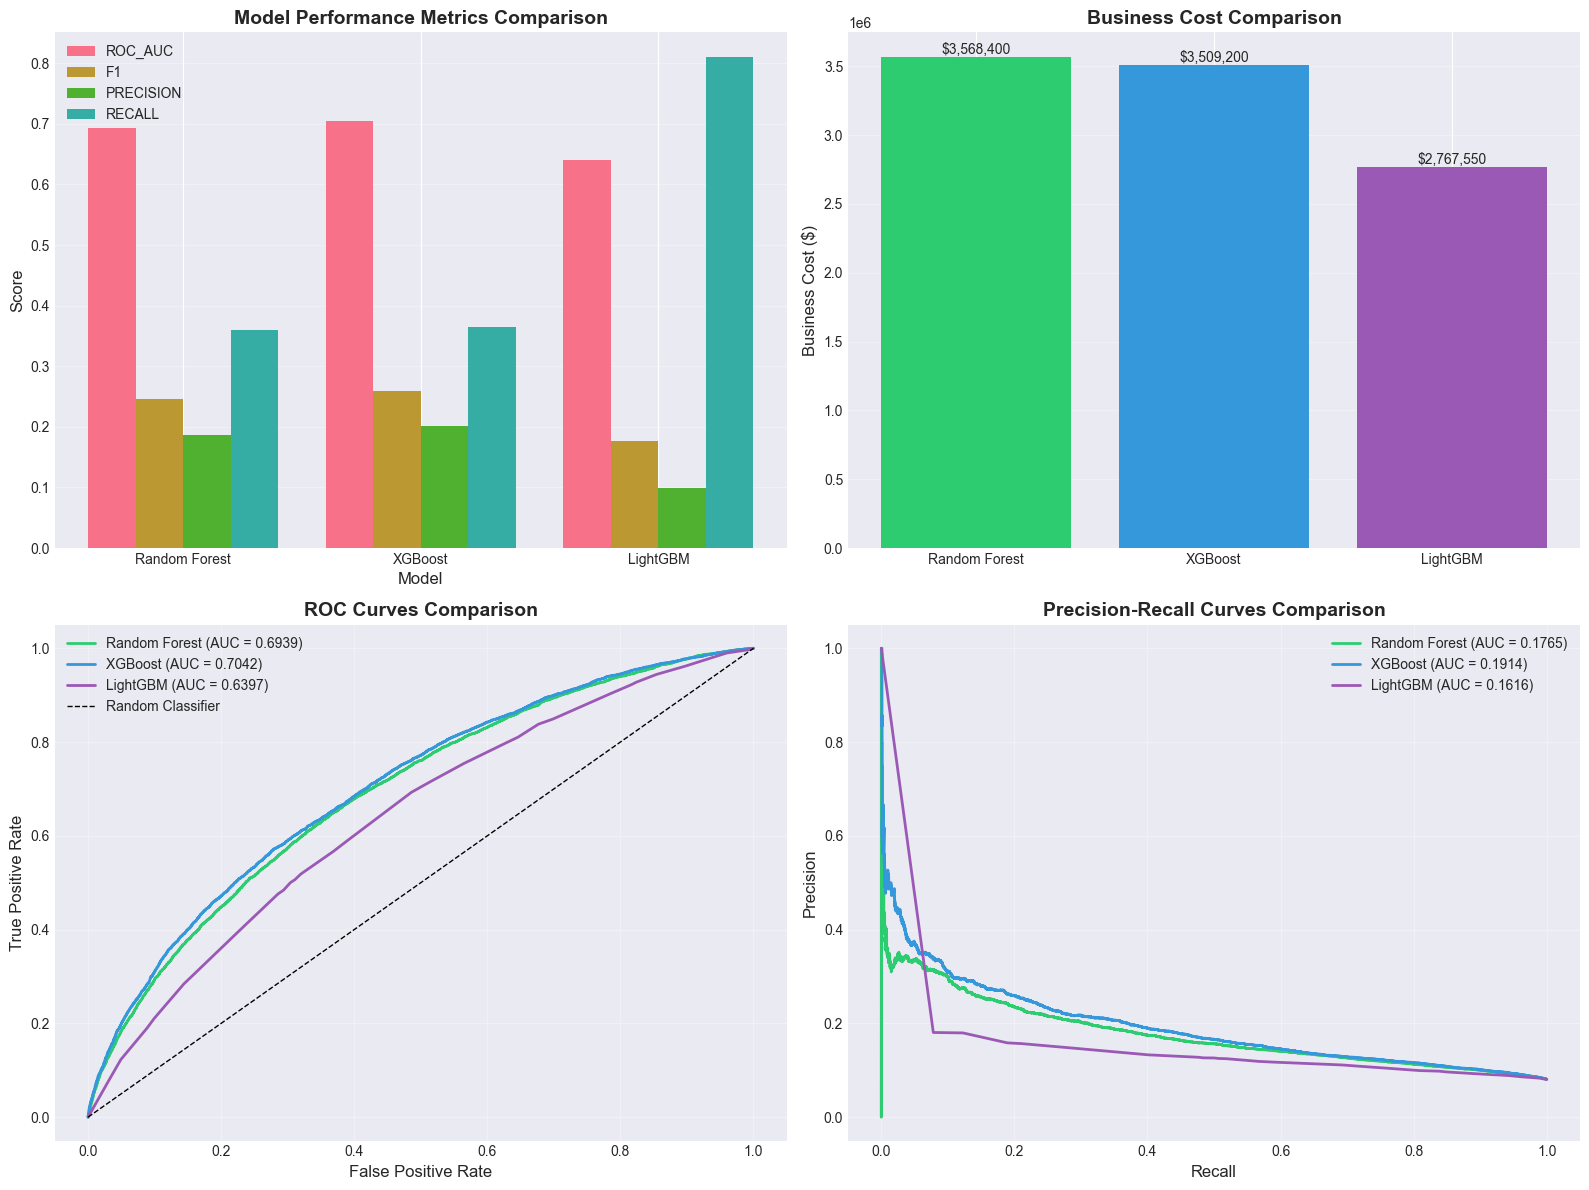

In [14]:
# Visualize Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Metrics Comparison
ax1 = axes[0, 0]
metrics = ['roc_auc', 'f1', 'precision', 'recall']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics):
    ax1.bar(x + i*width, comparison_df[metric], width, label=metric.upper())

ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(comparison_df['model'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Business Cost Comparison
ax2 = axes[0, 1]
colors = ['#2ecc71', '#3498db', '#9b59b6']
bars = ax2.bar(comparison_df['model'], comparison_df['business_cost'], color=colors)
ax2.set_ylabel('Business Cost ($)', fontsize=12)
ax2.set_title('Business Cost Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}',
            ha='center', va='bottom', fontsize=10)

# 3. ROC Curves
ax3 = axes[1, 0]
models_probs = [
    ('Random Forest', y_prob_rf, '#2ecc71'),
    ('XGBoost', y_prob_xgb, '#3498db'),
    ('LightGBM', y_prob_lgb, '#9b59b6')
]

for name, probs, color in models_probs:
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)
    ax3.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', 
            linewidth=2, color=color)

ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax3.set_xlabel('False Positive Rate', fontsize=12)
ax3.set_ylabel('True Positive Rate', fontsize=12)
ax3.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Precision-Recall Curves
ax4 = axes[1, 1]
for name, probs, color in models_probs:
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall_curve, precision_curve)
    ax4.plot(recall_curve, precision_curve, 
            label=f'{name} (AUC = {pr_auc:.4f})',
            linewidth=2, color=color)

ax4.set_xlabel('Recall', fontsize=12)
ax4.set_ylabel('Precision', fontsize=12)
ax4.set_title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Confusion Matrix Visualization

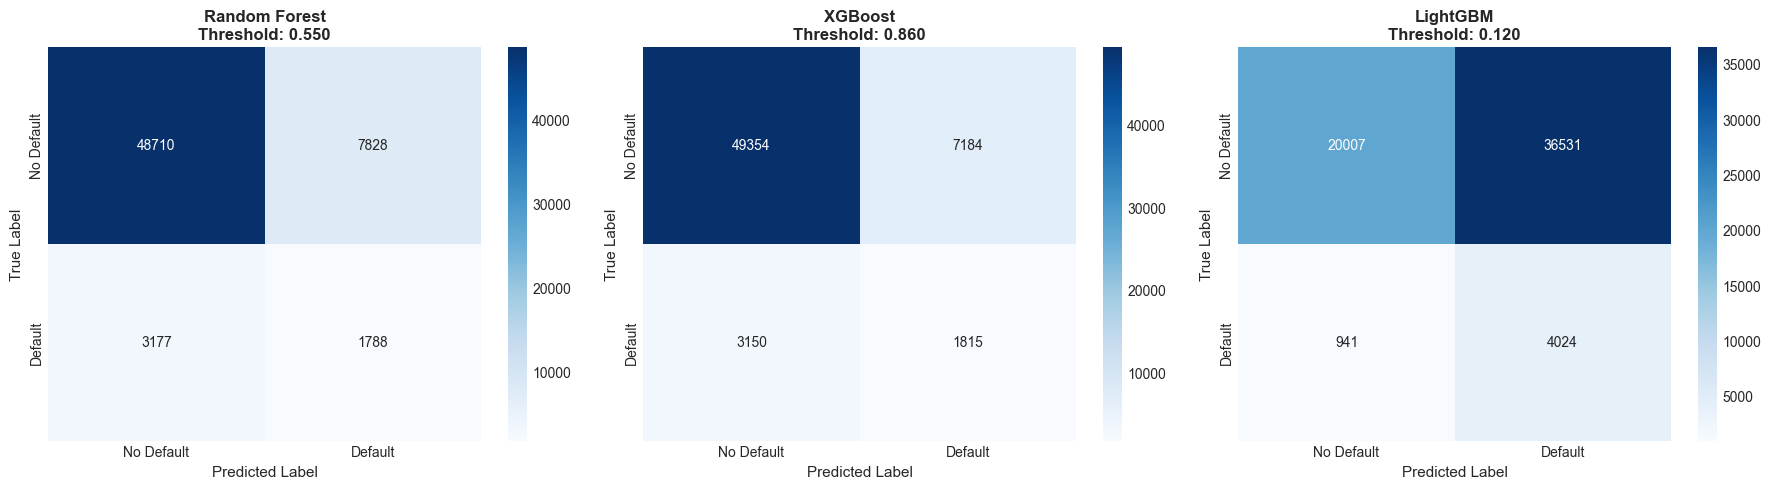

In [15]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_preds = [
    ('Random Forest', y_prob_rf, rf_optimal['threshold']),
    ('XGBoost', y_prob_xgb, xgb_optimal['threshold']),
    ('LightGBM', y_prob_lgb, lgb_optimal['threshold'])
]

for idx, (name, probs, threshold) in enumerate(models_preds):
    y_pred = (probs >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['No Default', 'Default'],
               yticklabels=['No Default', 'Default'])
    axes[idx].set_title(f'{name}\nThreshold: {threshold:.3f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

## Ensemble Model: Voting Classifier

In [16]:
# Create Ensemble Model (Soft Voting)
print("="*80)
print("ENSEMBLE MODEL - SOFT VOTING")
print("="*80)

# Average probabilities from all models
y_prob_ensemble = (y_prob_rf + y_prob_xgb + y_prob_lgb) / 3

print("\n🔄 Finding optimal threshold for ensemble...")
ensemble_optimal, ensemble_threshold_df = find_optimal_threshold(y_test, y_prob_ensemble, metric='f1')

print(f"\nOptimal Threshold: {ensemble_optimal['threshold']:.3f}")
print(f"F1-Score: {ensemble_optimal['f1']:.4f}")
print(f"Precision: {ensemble_optimal['precision']:.4f}")
print(f"Recall: {ensemble_optimal['recall']:.4f}")

# Evaluate ensemble
ensemble_results = evaluate_model(y_test, y_prob_ensemble, 
                                 ensemble_optimal['threshold'], 'Ensemble (Average)')

ENSEMBLE MODEL - SOFT VOTING

🔄 Finding optimal threshold for ensemble...

Optimal Threshold: 0.500
F1-Score: 0.2521
Precision: 0.1816
Recall: 0.4123
ENSEMBLE (AVERAGE) - DETAILED EVALUATION

Optimal Threshold: 0.500

📊 Performance Metrics:
  ROC-AUC: 0.7027
  F1-Score: 0.2521
  Precision: 0.1816
  Recall: 0.4123
  Balanced Accuracy: 0.6245

📋 Classification Report:
                precision    recall  f1-score   support

No Default (0)     0.9419    0.8368    0.8862     56538
   Default (1)     0.1816    0.4123    0.2521      4965

      accuracy                         0.8025     61503
     macro avg     0.5617    0.6245    0.5692     61503
  weighted avg     0.8805    0.8025    0.8350     61503


💼 Business Metrics:
  True Positives (Caught defaults): 2,047
  False Negatives (Missed defaults): 2,918
  False Positives (Rejected good customers): 9,228
  True Negatives (Approved good customers): 47,310
  Default Detection Rate: 41.23%

💰 Estimated Business Cost: $3,379,400


## Final Comparison with Ensemble

In [17]:
# Final Comparison
print("="*80)
print("FINAL MODEL COMPARISON (Including Ensemble)")
print("="*80)

final_comparison = pd.DataFrame([rf_results, xgb_results, lgb_results, ensemble_results])
final_comparison = final_comparison[['model', 'threshold', 'roc_auc', 'f1', 'precision', 
                                    'recall', 'balanced_accuracy', 'business_cost']]

print("\n", final_comparison.to_string(index=False))

# Highlight best performer
print("\n" + "="*80)
print("RECOMMENDED MODEL")
print("="*80)

best_f1_idx = final_comparison['f1'].idxmax()
best_model = final_comparison.loc[best_f1_idx]

print(f"\n🌟 Best Overall Model: {best_model['model']}")
print(f"  Threshold: {best_model['threshold']:.3f}")
print(f"  ROC-AUC: {best_model['roc_auc']:.4f}")
print(f"  F1-Score: {best_model['f1']:.4f}")
print(f"  Precision: {best_model['precision']:.4f}")
print(f"  Recall: {best_model['recall']:.4f}")
print(f"  Business Cost: ${best_model['business_cost']:,.0f}")

FINAL MODEL COMPARISON (Including Ensemble)

              model  threshold  roc_auc       f1  precision   recall  balanced_accuracy  business_cost
     Random Forest       0.55 0.693936 0.245251   0.185940 0.360121           0.610833        3568400
           XGBoost       0.86 0.704240 0.259954   0.201689 0.365559           0.619247        3509200
          LightGBM       0.12 0.639720 0.176801   0.099223 0.810473           0.582171        2767550
Ensemble (Average)       0.50 0.702676 0.252094   0.181552 0.412286           0.624534        3379400

RECOMMENDED MODEL

🌟 Best Overall Model: XGBoost
  Threshold: 0.860
  ROC-AUC: 0.7042
  F1-Score: 0.2600
  Precision: 0.2017
  Recall: 0.3656
  Business Cost: $3,509,200


## Save All Models and Results

In [18]:
# Save Models and Results
print("="*80)
print("SAVING MODELS AND RESULTS")
print("="*80)

output_dir = r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models"

# Save models
joblib.dump(rf_model, f"{output_dir}\\rf_model_optimized.pkl")
joblib.dump(xgb_model, f"{output_dir}\\xgb_model_optimized.pkl")
joblib.dump(lgb_model, f"{output_dir}\\lgb_model_optimized.pkl")

# Save metadata
metadata = {
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'models': {
        'random_forest': {
            'threshold': rf_optimal['threshold'],
            'metrics': rf_results
        },
        'xgboost': {
            'threshold': xgb_optimal['threshold'],
            'metrics': xgb_results
        },
        'lightgbm': {
            'threshold': lgb_optimal['threshold'],
            'metrics': lgb_results
        },
        'ensemble': {
            'threshold': ensemble_optimal['threshold'],
            'metrics': ensemble_results
        }
    },
    'comparison': final_comparison.to_dict('records'),
    'best_model': best_model.to_dict()
}

joblib.dump(metadata, f"{output_dir}\\ensemble_comparison_metadata.pkl")

# Save comparison DataFrame
final_comparison.to_csv(f"{output_dir}\\model_comparison.csv", index=False)

print("\n✅ Random Forest model saved")
print("✅ XGBoost model saved")
print("✅ LightGBM model saved")
print("✅ Metadata saved")
print("✅ Comparison CSV saved")

print("\n🎉 All models and results saved successfully!")

SAVING MODELS AND RESULTS

✅ Random Forest model saved
✅ XGBoost model saved
✅ LightGBM model saved
✅ Metadata saved
✅ Comparison CSV saved

🎉 All models and results saved successfully!


## Summary and Recommendations

In [19]:
# Final Summary
print("="*80)
print("SUMMARY AND RECOMMENDATIONS")
print("="*80)

print("\n📊 Models Trained:")
print("  1. Random Forest with balanced class weights")
print("  2. XGBoost with scale_pos_weight")
print("  3. LightGBM with scale_pos_weight")
print("  4. Ensemble (soft voting average)")

print("\n🎯 Key Findings:")
print(f"  Best F1-Score: {final_comparison['f1'].max():.4f} ({final_comparison.loc[final_comparison['f1'].idxmax(), 'model']})")
print(f"  Best ROC-AUC: {final_comparison['roc_auc'].max():.4f} ({final_comparison.loc[final_comparison['roc_auc'].idxmax(), 'model']})")
print(f"  Best Recall: {final_comparison['recall'].max():.4f} ({final_comparison.loc[final_comparison['recall'].idxmax(), 'model']})")
print(f"  Lowest Cost: ${final_comparison['business_cost'].min():,.0f} ({final_comparison.loc[final_comparison['business_cost'].idxmin(), 'model']})")

print("\n💡 Recommendations:")
print(f"  Use {best_model['model']} for production")
print(f"  Set classification threshold to {best_model['threshold']:.3f}")
print(f"  Expected F1-Score: {best_model['f1']:.4f}")
print(f"  Expected business cost: ${best_model['business_cost']:,.0f}")

print("\n" + "="*80)
print("NOTEBOOK EXECUTION COMPLETED")
print("="*80)

SUMMARY AND RECOMMENDATIONS

📊 Models Trained:
  1. Random Forest with balanced class weights
  2. XGBoost with scale_pos_weight
  3. LightGBM with scale_pos_weight
  4. Ensemble (soft voting average)

🎯 Key Findings:
  Best F1-Score: 0.2600 (XGBoost)
  Best ROC-AUC: 0.7042 (XGBoost)
  Best Recall: 0.8105 (LightGBM)
  Lowest Cost: $2,767,550 (LightGBM)

💡 Recommendations:
  Use XGBoost for production
  Set classification threshold to 0.860
  Expected F1-Score: 0.2600
  Expected business cost: $3,509,200

NOTEBOOK EXECUTION COMPLETED
